## Install Libraries

In [6]:
%pip install umap-learn optuna
%pip install plotly
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import umap
import optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[I 2025-03-12 17:59:20,135] A new study created in memory with name: no-name-c5cf1987-1e98-4ed2-82de-7c525218072f
/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
[I 2025-03-12 17:59:21,277] Trial 0 finished with value: 0.3475908637046814 and parameters: {'n_neighbors': 14, 'min_dist': 0.4809884379092416, 'n_components': 17}. Best is trial 0 with value: 0.3475908637046814.
/Users/qingshuzhao/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
[I 2025-03-12 17:59:22,450] Trial 1 finished with value: 0.3452166020870209 and parameters: {'n

Best UMAP hyperparameters: {'n_neighbors': 5, 'min_dist': 0.010155758337688794, 'n_components': 14}
Saved reduced dataset with dG_exp.


/var/folders/l3/px3tmzm113q8q08w_5t0ktkm0000gn/T/ipykernel_66702/2156932253.py:81: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Figure size 1000x400 with 0 Axes>

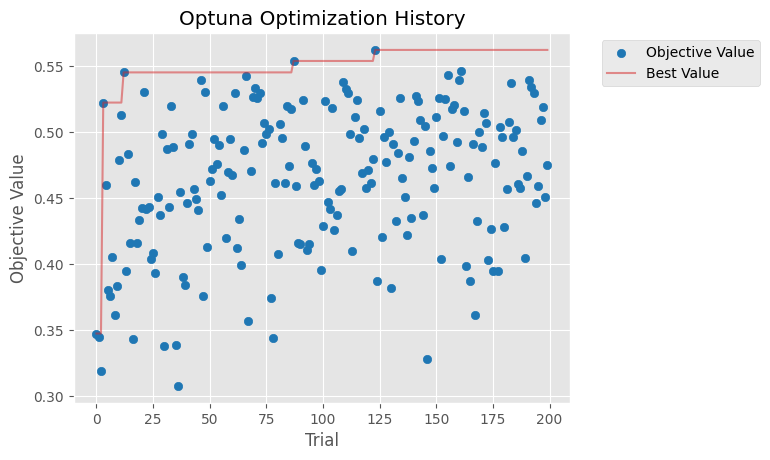

/var/folders/l3/px3tmzm113q8q08w_5t0ktkm0000gn/T/ipykernel_66702/2156932253.py:86: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Figure size 1000x400 with 0 Axes>

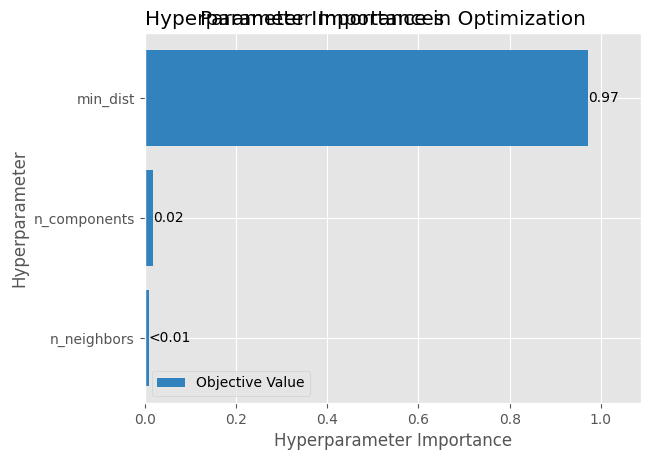

/var/folders/l3/px3tmzm113q8q08w_5t0ktkm0000gn/T/ipykernel_66702/2156932253.py:91: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


<Figure size 1000x400 with 0 Axes>

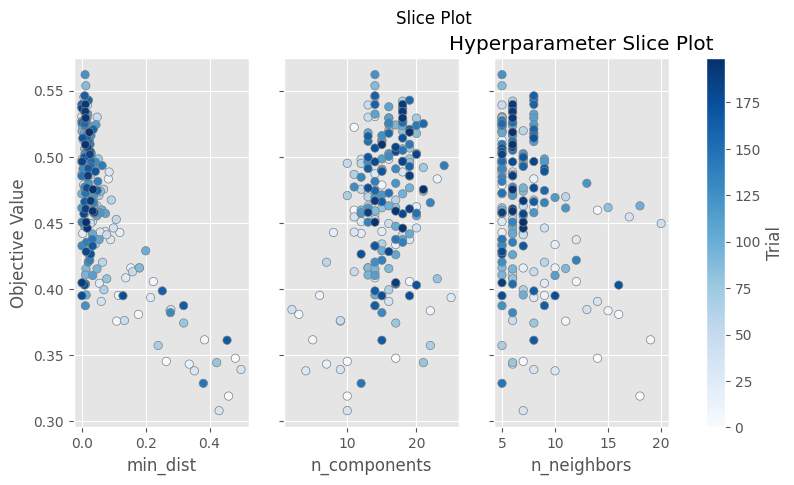

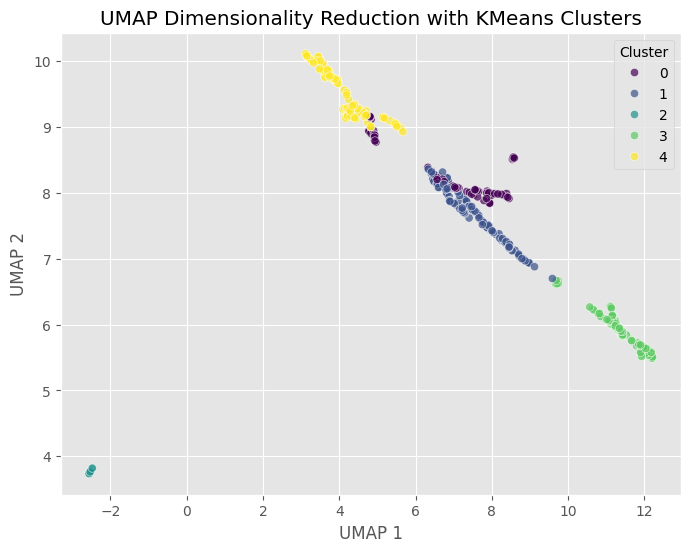

In [7]:
import pandas as pd
import numpy as np
import umap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_slice
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

def load_training_data(file_path):
    """Load and preprocess training data."""
    df_energy = pd.read_csv(file_path)
    df_energy = df_energy.dropna().reset_index(drop=True)
    df_energy['dG_exp'] = (1.98722 * 298.15 * np.log(df_energy['kd_molar']) / 1000)
    df_energy.drop(columns=['resolution', 'kd_molar', 'pdb_id'], inplace=True)
    return df_energy

# Load and preprocess the data
df_energy = load_training_data("/Users/qingshuzhao/Documents/ML_PPI_project/training_dataset/training_set_3_11/top_504_iforest_dropout.csv")
X = df_energy.drop(columns=['dG_exp'])
y = df_energy['dG_exp']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the Optuna objective function
def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 5, 20)
    min_dist = trial.suggest_float("min_dist", 0.0, 0.5)
    n_components = trial.suggest_int("n_components", 2, 25)

    # Apply UMAP with the suggested hyperparameters
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=42
    )
    X_embedded = umap_model.fit_transform(X_scaled)

    # Perform KMeans clustering on the UMAP-reduced data
    kmeans = KMeans(n_clusters=5, random_state=42).fit(X_embedded)
    labels = kmeans.labels_

    # Calculate silhouette score
    score = silhouette_score(X_embedded, labels)
    return score

# Create an Optuna study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

# Print the best UMAP hyperparameters
print("Best UMAP hyperparameters:", study.best_params)

# Apply UMAP with the best hyperparameters
best_umap = umap.UMAP(
    n_neighbors=study.best_params["n_neighbors"],
    min_dist=study.best_params["min_dist"],
    n_components=study.best_params["n_components"],
    random_state=42
)
X_reduced = best_umap.fit_transform(X_scaled)

# Save the reduced data along with dG_exp
reduced_df = pd.DataFrame(X_reduced, columns=[f"UMAP_{i+1}" for i in range(study.best_params["n_components"])])
reduced_df["dG_exp"] = y.values  # Add dG_exp to the dataset
reduced_df.to_csv("/Users/qingshuzhao/Documents/ML_PPI_project/training_dataset/PPI_504_umap_reduced.csv", index=False)

print("Saved reduced dataset with dG_exp.")

# ** Optuna Visualization **
plt.figure(figsize=(10, 4))
plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.show()

plt.figure(figsize=(10, 4))
plot_param_importances(study)
plt.title("Parameter Importance in Optimization")
plt.show()

plt.figure(figsize=(10, 4))
plot_slice(study)
plt.title("Hyperparameter Slice Plot")
plt.show()

# ** UMAP Scatter Plot with Clusters **
plt.figure(figsize=(8, 6))
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_reduced)
labels = kmeans.labels_

sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("UMAP Dimensionality Reduction with KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()